In [265]:
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
import hvplot

import datetime
from datetime import date, timedelta
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
%matplotlib inline

load_dotenv()

True

In [266]:
def fetch_data():
    """Fetches the latest prices."""
   # Set Alpaca API key and secret

    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
    
    alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")
    today = date.today()
    start = date.today() - timedelta(days=600)

    # Set the tickers & timeframe
    tickers = ["SPY"]

    timeframe = "1D"

    #Get Closing prices for past 60 days

    df = alpaca.get_barset(
        tickers,
        timeframe,
        start = start,
        end = today
    ).df
    #figure out another way to clean and prep the data here - hard coded for now 
    df_clean = df['SPY']

    # Display sample data
    return df_clean

In [267]:
data = fetch_data()
data = data.reset_index()
data = data.set_index('time', drop=True)
data['close of tomorrow'] = data['close'].shift(-1)
data

,open,high,low,close,volume,close of tomorrow
time,,,,,,
2020-10-28 00:00:00-04:00,332.100,338.2483,326.1300,326.67,107939571,329.990
2020-10-29 00:00:00-04:00,326.910,333.3950,325.0900,329.99,74362731,326.530
2020-10-30 00:00:00-04:00,328.280,329.6900,322.6000,326.53,93413096,330.210
2020-11-02 00:00:00-05:00,330.200,332.3600,327.2400,330.21,69167640,335.970
2020-11-03 00:00:00-05:00,333.690,338.2500,330.2935,335.97,74330624,343.495
...,...,...,...,...,...,...
2021-03-17 00:00:00-04:00,394.530,398.1200,393.3000,397.22,61876016,391.410
2021-03-18 00:00:00-04:00,394.475,396.7200,390.7500,391.41,98794050,389.500
2021-03-19 00:00:00-04:00,389.880,391.5690,387.1500,389.50,93819590,392.540


In [268]:
# Drop Null values -- can cause error --# Consider replacing Nan values with a value to keep last row 
data.dropna(inplace=True)
data

,open,high,low,close,volume,close of tomorrow
time,,,,,,
2020-10-28 00:00:00-04:00,332.100,338.2483,326.1300,326.67,107939571,329.990
2020-10-29 00:00:00-04:00,326.910,333.3950,325.0900,329.99,74362731,326.530
2020-10-30 00:00:00-04:00,328.280,329.6900,322.6000,326.53,93413096,330.210
2020-11-02 00:00:00-05:00,330.200,332.3600,327.2400,330.21,69167640,335.970
2020-11-03 00:00:00-05:00,333.690,338.2500,330.2935,335.97,74330624,343.495
...,...,...,...,...,...,...
2021-03-16 00:00:00-04:00,397.070,397.8300,395.0800,395.94,65719794,397.220
2021-03-17 00:00:00-04:00,394.530,398.1200,393.3000,397.22,61876016,391.410
2021-03-18 00:00:00-04:00,394.475,396.7200,390.7500,391.41,98794050,389.500


In [277]:
#Calculate additional data to use as features - add to dataframe



def generate_ema_macd__RSI_signals(df):
    
    def EWMA(data, ndays):
        EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(),
                     name = 'EWMA_' + str(ndays))
        data = data.join(EMA)
        return data

    def computeRSI (data, time_window):
        diff = data.diff(1).dropna()        # diff in one field(one day)

        #this preservers dimensions off diff values
        up_chg = 0 * diff
        down_chg = 0 * diff

        # up change is equal to the positive difference, otherwise equal to zero
        up_chg[diff > 0] = diff[ diff>0 ]

        # down change is equal to negative deifference, otherwise equal to zero
        down_chg[diff < 0] = diff[ diff < 0 ]

        # we set com=time_window-1 so we get decay alpha=1/time_window
        up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
        down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()

        rs = abs(up_chg_avg/down_chg_avg)
        rsi = 100 - 100/(1+rs)
        return rsi


    #Calculate RSI
    df['RSI'] = computeRSI (df['close'], 14)
    # Construct a buy and sell trading signals buy -1 sell - 0 -- Add more sophistication to this -- I wanted to have a signal that says buy when RSI is between 50 -70 or oversold and sell when overbought and RSI is between 30-50
    df['RSI Overbought'] = np.where(df['RSI'] > 70, 1.0, 0.0)
    df['RSI Oversold'] = np.where(df['RSI'] < 30, 1.0, 0.0)
    df['RSI Long'] = np.where(((df['RSI'] > 50) & (df['RSI'] < 70)) | (df['RSI'] < 30), 1.0, 0.0)
    df['RSI Short'] = np.where(((df['RSI'] > 30) & (df['RSI'] < 50)) | (df['RSI'] > 70), 1.0, 0.0)
    
    # Set short and long windows
    short_window = 5
    long_window = 13

    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df['EMA 5'] = df['close'].ewm(halflife=short_window).mean()
    df['EMA 13'] = df['close'].ewm(halflife=long_window).mean()

    # Construct a crossover trading signal
    df['crossover_long_5_13'] = np.where(df['EMA 5'] > df['EMA 13'], 1.0, 0.0)
    df['crossover_short_5_13'] = np.where(df['EMA 5'] < df['EMA 13'], -1.0, 0.0)
    df['crossover_signal_5_13'] = df['crossover_long_5_13'] + df['crossover_short_5_13']

     # Set short and long windows for 9 & 21 EMA
    short_window_9 = 9
    long_window_21 = 21

    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df['EMA 9'] = df['close'].ewm(halflife=short_window_9).mean()
    df['EMA 21'] = df['close'].ewm(halflife=long_window_21).mean()

    # Construct a crossover trading signal
    df['crossover_long_9_21'] = np.where(df['EMA 9'] > df['EMA 21'], 1.0, 0.0)
    df['crossover_short_9_21'] = np.where(df['EMA 9'] < df['EMA 21'], -1.0, 0.0)
    df['crossover_signal_9_21'] = df['crossover_long_9_21'] + df['crossover_short_9_21']
    
    # Set short and long windows for 55 & 200 EMA
    short_window_55 = 55
    long_window_200 = 200

    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df['EMA 55'] = df['close'].ewm(halflife=short_window_55).mean()
    df['EMA 200'] = df['close'].ewm(halflife=long_window_200).mean()

    # Construct a crossover trading signal
    df['crossover_long_55_200'] = np.where(df['EMA 55'] > df['EMA 200'], 1.0, 0.0)
    df['crossover_short_55_200'] = np.where(df['EMA 55'] < df['EMA 200'], -1.0, 0.0)
    df['crossover_signal_55_200'] = df['crossover_long_55_200'] + df['crossover_short_55_200']

    # Set short and long windows for 200 & 800 EMA
    short_window_200 = 200
    long_window_800 = 800

    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df['EMA 200'] = df['close'].ewm(halflife=short_window_200).mean()
    df['EMA 800'] = df['close'].ewm(halflife=long_window_800).mean()

    # Construct a crossover trading signal
    df['crossover_long_200_800'] = np.where(df['EMA 200'] > df['EMA 800'], 1.0, 0.0)
    df['crossover_short_200_800'] = np.where(df['EMA 200'] < df['EMA 800'], -1.0, 0.0)
    df['crossover_signal_200_800'] = df['crossover_long_200_800'] + df['crossover_short_200_800']
    
    # Calculate MACD
    
    EMA_8 = df['close'].ewm(halflife=8).mean()
    EMA_22 = df['close'].ewm(halflife=22).mean()
    macd = EMA_8 - EMA_22
    df['MACD H'] = macd
    df['MACD Signal'] = np.where(df['MACD H'] > 0, 1.0, 0.0)
    
    return df

In [278]:
data = generate_ema_macd__RSI_signals(data)
data = data.dropna()

C:\Users\jacob\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jacob\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jacob\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [279]:
#Function to pull yfinance recomendation - add this recomendation in as a feature to see if it improves the model 

def get_yf_recomendation():
    from yahoo_fin import stock_info as si 
    #change tickers to match the stock that is being traded - here we are trading the ETF SPY so multiple tickers are called
    tickers = ['AAPL','MSFT','AMZN','FB','GOOGL','GOOG','TSLA','JPM','JNJ']
    #tickers = si.tickers_sp500()
    recommendations = []
    for ticker in tickers:
        lhs_url = 'https://query2.finance.yahoo.com/v10/finance/quoteSummary/'
        rhs_url = '?formatted=true&crumb=swg7qs5y9UP&lang=en-US&region=US&' \
              'modules=upgradeDowngradeHistory,recommendationTrend,' \
              'financialData,earningsHistory,earningsTrend,industryTrend&' \
              'corsDomain=finance.yahoo.com'
              
        url =  lhs_url + ticker + rhs_url
        r = requests.get(url)
    if not r.ok:
        recommendation = 6
    try:
        result = r.json()['quoteSummary']['result'][0]
        recommendation =result['financialData']['recommendationMean']['fmt']
    except:
        recommendation = 6
    
    recommendations.append(recommendation)
    yfdf = pd.DataFrame(list(zip(tickers, recommendations)), columns =['Stock', 'Recommendations']) 
    yfdf = df.set_index('Stock')
    return yfdf


In [280]:
#define feauture and target values
X = data[['open', 'high', 'low', 'close', 'volume','EMA 9', 'EMA 21', 'EMA 5', 'EMA 13', 'RSI','MACD H','EMA 55','EMA 800', 'EMA 200']]
y = data[['close of tomorrow']]


X = np.array(X)
y = np.array(y)

In [281]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [282]:
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
X_scaler = scaler.fit(X)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
y_scaler = scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [283]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.08765931]
  [0.12873887]
  [0.17065053]
  [0.17019013]
  [0.07919719]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [1.        ]
  [0.03106346]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.18588747]
  [0.13734313]
  [0.11860817]
  [0.0699172 ]
  [0.26945912]
  [0.00983697]
  [0.01167813]
  [0.00710447]
  [0.01065714]
  [0.59944746]
  [0.02875116]
  [0.01362759]
  [0.01553198]
  [0.0150455 ]]

 [[0.01460988]
  [0.03568538]
  [0.07261725]
  [0.06470408]
  [0.18214587]
  [0.01767326]
  [0.02134085]
  [0.01211449]
  [0.01934892]
  [0.58103427]
  [0.02490585]
  [0.02501752]
  [0.02856597]
  [0.02766133]]] 

X_test sample values:
[[[0.84457569]
  [0.81707978]
  [0.83267776]
  [0.77920883]
  [0.31087023]
  [0.83536854]
  [0.77134217]
  [0.89441819]
  [0.79966028]
  [0.64066673]
  [1.        ]
  [0.76055286]
  [0.76878362]
  [0.76591412]]

 [[0.68884053]
  [0.72912511]
  [0.74765507]
  [0.6899724 ]
  [0.24162874]
  [0.8421492 ]
  [0.78379262]


In [284]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [285]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=90, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=45))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [286]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [287]:
# Show the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 14, 30)            3840      
_________________________________________________________________
dropout_21 (Dropout)         (None, 14, 30)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 14, 90)            43560     
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 90)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 45)                24480     
_________________________________________________________________
dropout_23 (Dropout)         (None, 45)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [288]:
# Train the model
model.fit(X_train, y_train, epochs=100, shuffle=False, batch_size=90, verbose=1)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.2789
Epoch 2/100
1/1 [==============================] - 0s 18ms/step - loss: 0.2278
Epoch 3/100
1/1 [==============================] - 0s 19ms/step - loss: 0.1793
Epoch 4/100
1/1 [==============================] - 0s 17ms/step - loss: 0.1394
Epoch 5/100
1/1 [==============================] - 0s 18ms/step - loss: 0.1076
Epoch 6/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0731
Epoch 7/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0425
Epoch 8/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0241
Epoch 9/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0272
Epoch 10/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0354
Epoch 11/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0447
Epoch 12/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0466
Epoch 13/100
1/1 [==============================] -

In [289]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)


1/1 [==============================] - 1s 775ms/step - loss: 0.0346


0.034617017954587936

In [290]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)
trained_predicted = model.predict(X_train)
#print(predicted)
#print(trained_predicted)

In [291]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
train_predicted_prices = scaler.inverse_transform(trained_predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
train_real_prices = scaler.inverse_transform(y_train.reshape(-1,1))

In [292]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = data.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.tail()

,Actual,Predicted
time,,
2021-03-16 00:00:00-04:00,397.22,396.887695
2021-03-17 00:00:00-04:00,391.41,397.213104
2021-03-18 00:00:00-04:00,389.50,396.577667
2021-03-19 00:00:00-04:00,392.54,394.857178
2021-03-22 00:00:00-04:00,389.59,395.406189


In [293]:
# Create another DataFrame of trained Real and Predicted values
trained_stocks = pd.DataFrame({
    "Actual": train_real_prices.ravel(),
    "Predicted": train_predicted_prices.ravel()
}, index = data.index[-len(train_real_prices): ]) 

# Show the DataFrame's head
trained_stocks.tail()

,Actual,Predicted
time,,
2021-03-16 00:00:00-04:00,392.69,390.376923
2021-03-17 00:00:00-04:00,392.34,391.582703
2021-03-18 00:00:00-04:00,392.43,392.775330
2021-03-19 00:00:00-04:00,390.75,392.666138
2021-03-22 00:00:00-04:00,390.02,392.365234


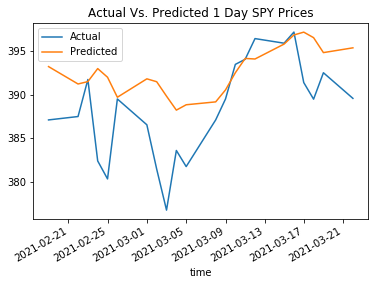

In [294]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted 1 Day SPY Prices")

In [295]:
data2 = data
data2.tail(2)

,open,high,low,close,volume,close of tomorrow,RSI,RSI Overbought,RSI Oversold,RSI Long,...,MACD Signal,EMA 55,EMA 200,crossover_long_55_200,crossover_short_55_200,crossover_signal_55_200,EMA 800,crossover_long_200_800,crossover_short_200_800,crossover_signal_200_800
time,,,,,,,,,,,,,,,,,,,,,
2021-03-19 00:00:00-04:00,389.88,391.569,387.15,389.50,93819590,392.54,51.386959,0.0,0.0,1.0,...,1.0,380.721098,378.637680,1.0,0.0,1.0,378.020016,1.0,0.0,1.0
2021-03-22 00:00:00-04:00,390.03,394.070,389.97,392.54,61372559,389.59,54.851297,0.0,0.0,1.0,...,1.0,380.946246,378.826182,1.0,0.0,1.0,378.197130,1.0,0.0,1.0


In [296]:
combined_stocks_df = pd.concat([stocks, trained_stocks])
combined_stocks_df.reset_index(inplace=True)
#combined_stocks_df
data2.reset_index(inplace = True)

data2['Predicted'] = combined_stocks_df['Predicted']


C:\Users\jacob\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [297]:
#combined_stocks_df[combined_stocks_df.index.duplicated()]


In [298]:
#data2.dropna(inplace=True)
data2.set_index('time')


,open,high,low,close,volume,close of tomorrow,RSI,RSI Overbought,RSI Oversold,RSI Long,...,EMA 55,EMA 200,crossover_long_55_200,crossover_short_55_200,crossover_signal_55_200,EMA 800,crossover_long_200_800,crossover_short_200_800,crossover_signal_200_800,Predicted
time,,,,,,,,,,,,,,,,,,,,,
2020-12-08 00:00:00-05:00,367.720,370.7800,367.67,370.1599,32702217,366.89,71.758048,1.0,0.0,0.0,...,363.404200,363.231864,1.0,0.0,1.0,363.182936,1.0,0.0,1.0,393.246979
2020-12-09 00:00:00-05:00,370.880,371.0500,365.95,366.8900,60700254,366.72,59.481424,0.0,0.0,1.0,...,363.643255,363.466488,1.0,0.0,1.0,363.416136,1.0,0.0,1.0,391.246368
2020-12-10 00:00:00-05:00,365.370,367.8600,364.43,366.7200,47851654,366.28,58.917074,0.0,0.0,1.0,...,363.843058,363.663223,1.0,0.0,1.0,363.611831,1.0,0.0,1.0,391.520477
2020-12-11 00:00:00-05:00,364.900,366.7402,363.26,366.2800,47917103,364.61,57.399112,0.0,0.0,1.0,...,363.993430,363.812922,1.0,0.0,1.0,363.761157,1.0,0.0,1.0,393.018066
2020-12-14 00:00:00-05:00,368.640,369.8000,364.47,364.6100,54732478,369.57,51.930345,0.0,0.0,1.0,...,364.029692,363.856195,1.0,0.0,1.0,363.806182,1.0,0.0,1.0,392.022461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-16 00:00:00-04:00,397.070,397.8300,395.08,395.9400,65719794,397.22,60.778456,0.0,0.0,1.0,...,380.000906,378.037170,1.0,0.0,1.0,377.455980,1.0,0.0,1.0,390.376923
2021-03-17 00:00:00-04:00,394.530,398.1200,393.30,397.2200,61876016,391.41,62.002619,0.0,0.0,1.0,...,380.335649,378.305456,1.0,0.0,1.0,377.705560,1.0,0.0,1.0,391.582703
2021-03-18 00:00:00-04:00,394.475,396.7200,390.75,391.4100,98794050,389.50,53.795163,0.0,0.0,1.0,...,380.549457,378.486823,1.0,0.0,1.0,377.876608,1.0,0.0,1.0,392.775330


In [299]:
data2['Difference'] = abs(data2['close of tomorrow'] - data2['Predicted'])
data2['Avg off'] = data2['Difference'].mean()
print(data2['Avg off'].tail(1))

70    12.49109
Name: Avg off, dtype: float64


C:\Users\jacob\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\jacob\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [300]:
#Lets create a new data frame that records if we should buy or sell based the price of tomorrow's close price
#We will create a column for predicting the price moved up or down Call/Put -- Call = 1 Put = 0
#Using Open, High, Low, Close and Volume here but considered pulling in data from Alphavantage and include more data as parameters -- train both multiple classification models and determine which is best 
#Consider training Random Forrest Model to predict call or put - taraget will be call/put - features can be all data than can be pulled except close of tomorrow and predicted
#Create a feature that uses the predicted value of model 1 to create a buy or sell signal -- Predicted Outcome 

signals_df = data2.drop(columns=['Difference', 'Avg off'])
signals_df['Call/Put'] = np.where(signals_df['close'] < signals_df['close of tomorrow'], 1, 0)
signals_df['Predicted Outcome'] = np.where(signals_df['close'] < signals_df['Predicted'], 1, 0)
signals_df.tail(2)


,time,open,high,low,close,volume,close of tomorrow,RSI,RSI Overbought,RSI Oversold,...,crossover_long_55_200,crossover_short_55_200,crossover_signal_55_200,EMA 800,crossover_long_200_800,crossover_short_200_800,crossover_signal_200_800,Predicted,Call/Put,Predicted Outcome
69,2021-03-19 00:00:00-04:00,389.88,391.569,387.15,389.50,93819590,392.54,51.386959,0.0,0.0,...,1.0,0.0,1.0,378.020016,1.0,0.0,1.0,392.666138,1,1
70,2021-03-22 00:00:00-04:00,390.03,394.070,389.97,392.54,61372559,389.59,54.851297,0.0,0.0,...,1.0,0.0,1.0,378.197130,1.0,0.0,1.0,392.365234,0,0


In [301]:
#define feauture and target values
X2 = signals_df[['open', 'high', 'low', 'close', 'volume', 'RSI Overbought', 'RSI Oversold', 'RSI Long', 'RSI Short', 'crossover_signal_5_13', 'crossover_long_5_13', 'crossover_short_5_13', 'crossover_signal_9_21', 'crossover_long_9_21', 'crossover_short_9_21','crossover_signal_55_200', 'crossover_long_55_200', 'crossover_short_55_200', 'crossover_signal_200_800', 'crossover_long_200_800', 'crossover_short_200_800', 'MACD Signal']]
y2 = signals_df[['Call/Put']]

X2 = np.array(X2)
y2 = np.array(y2)

# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X2))
X_train = X2[: split]
X_test = X2[split:]
y_train = y2[: split]
y_test = y2[split:]

In [302]:
y_test

array([[0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]])

In [303]:
#signals_df

In [304]:
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test

array([[0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]])

In [305]:
from sklearn.ensemble import RandomForestClassifier
# Fit a SKLearn linear regression using just the training set (X_train, Y_train
# Try another model type - XGBoost instead of Random Forest Classifer  --- try changing some of the hyper paremeters -- cc- alpha, max leaf nodes, max depth,  

model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = pd.DataFrame({'results': y_test.ravel()})

Results["Predicted Value"] = predictions
Results

C:\Users\jacob\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


,results,Predicted Value
0,0,1
1,1,1
2,1,1
3,0,0
4,0,1
5,1,1
6,0,1
7,0,1
8,0,1
9,1,1


In [306]:
#evaulute model performance 
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)




array([[ 2,  9],
       [ 0, 11]], dtype=int64)

In [307]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.18      0.31        11
           1       0.55      1.00      0.71        11

    accuracy                           0.59        22
   macro avg       0.78      0.59      0.51        22
weighted avg       0.78      0.59      0.51        22

